<a href="https://colab.research.google.com/github/up2113232/up2113232_coursework/blob/dev/Q2_folder/Q2_NN_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Gaming Mental Health Prediction with Neural Networks
## Predicting GAD_T, SWL_T, and SPIN_T Scores from Gaming Behavior

This notebook demonstrates how to build a neural network to predict mental health scores
(GAD_T = Anxiety, SWL_T = Life Satisfaction, SPIN_T = Social Phobia) based on gaming habits.

**Dataset:** Online Gaming Anxiety Data from Kaggle
**Target Variables:** GAD_T, SWL_T, SPIN_T


First things first we have to import all of our important libraries that will be used.

This code is essential for setting up our project. We're importing various libraries that contain functions we'll need for data handling, machine learning, and creating visualisations.


In [15]:
# Import necessary libraries
import sys # Used for system-specific parameters and functions, such as modifying the Python path.
import os  # Provides a way of using operating system dependent functionality, such as file paths.

# Add parent directory to path to import our functions
# This line ensures Python can find our 'functions.py' file, which contains
# helper functions for data cleaning, encoding, splitting, and scaling.
sys.path.append('..')

# Core data manipulation and visualisation libraries
# pandas is crucial for handling data in tables (DataFrames).
import pandas as pd
# numpy is used for numerical operations, especially with arrays.
import numpy as np
# matplotlib is a foundational library for creating visualisations.
import matplotlib.pyplot as plt
# seaborn is built on matplotlib and provides a higher-level graphics.
import seaborn as sns

# Machine learning and preprocessing libraries from scikit-learn
# train_test_split: for dividing data into training and testing sets.
# cross_val_score: for evaluating model performance using cross-validation.
# GridSearchCV: for hyperparameter tuning (finding the best parameters for a model).
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# StandardScaler: for standardising features by removing the mean and scaling to unit variance.
# LabelEncoder: for converting categorical labels into numerical format.
# MinMaxScaler: for scaling features to a given range, usually between zero and one.
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
# mean_squared_error, mean_absolute_error, r2_score: metrics to evaluate regression model performance.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# MLPRegressor: Multi-layer Perceptron regressor, a type of neural network for regression tasks.
from sklearn.neural_network import MLPRegressor
# MultiOutputRegressor: a strategy for fitting a single regressor on multiple targets.
from sklearn.multioutput import MultiOutputRegressor

# System and warnings
# This line is used to ignore warning messages that might clutter the output.
import warnings
warnings.filterwarnings('ignore')


Then we will load the functions we will use in this notebook from our functions file

This imports specific helper functions from our `functions.py` file. We put common, repeatable steps into separate functions. This makes our main notebook code much cleaner, easier to read, and less repetitive, which helps us focus on the main steps without getting bogged down in every detail of the data preparation.

In [16]:
# From our custom 'functions.py' file, we import specific helper functions.
# These functions encapsulate common data processing steps, making our main notebook cleaner and more organised.
# - clean_data: handles initial data cleaning (e.g., duplicates, basic missing value handling).
# - encode_features: converts non-numerical (categorical) data into numerical format that machine learning models can understand.
# - split_data: divides the dataset into training and testing sets.
# - scale_features: normalises or standardises numerical features.
from functions import clean_data, encode_features, split_data, scale_features
from functions import plot_r2_values, plot_mae_values


Now we have to load our data as a pandas data frame so we can manipulate it easier.

This code is responsible for loading our dataset from a CSV file into a pandas DataFrame. A DataFrame is like a table (similar to a spreadsheet) that pandas uses to store and organise data, making it much easier to work with.

In [17]:
# Load the dataset from a CSV file into a pandas DataFrame.
# The 'encoding' parameter is specified to handle potential character encoding issues in the file.
# We use a try-except block to gracefully handle the case where the file might not be found.
try:
  df = pd.read_csv('gaming_anxiety_data.csv', encoding='ISO-8859-1')

except FileNotFoundError:
  print(" File not found! Please upload your dataset first.")


Selecting our target and feature columns

Here, we're selecting the specific columns from our DataFrame that we want to use for our machine learning task. We divide them into two groups:

- feature_columns, These are our input features, the pieces of information that the neural network will use to try and make predictions. These are the independent variables.
-target_columns, These are our target variables, the mental health scores that we want the neural network to predict. These are the dependent variables.

We then create a new DataFrame `df` that *only* contains these selected columns so that we don't deal with any other data that we're not using

In [18]:
# Define the columns that will be used as input features for our Neural Network.
# These are the independent variables (X) that the network will use to make predictions.
feature_columns = ['GADE', 'Game', 'Hours', 'earnings', 'whyplay',
                   'streams', 'Narcissism', 'Gender',
                   'Age', 'Work', 'Playstyle']

# Define the target columns. These are the dependent variables (y) we want to predict.
# Our network will try to learn the relationship between 'feature_columns' and 'target_columns'.
target_columns = ['GAD_T', 'SWL_T', 'SPIN_T']

# Create a new DataFrame 'df' containing only the selected feature and target columns.
df = df[feature_columns + target_columns].copy()


Now we have to clean our data by removing duplicate rows and showing us if there are any missing values in our data. It's a crucial first step to ensure our data is tidy before we start building models. To remove missing values we try to replace them with common values in the data, so to not lose hundreds of columns if we were to just delete rows with empty columns.

In [19]:
# Calls the 'clean_data' function to handle initial data cleaning steps.
# This function removes duplicate rows and displays information about missing values.
# The cleaned data is stored in a new DataFrame called 'df_cleaned_initial'.
print("Cleaning dataset...")
df_cleaned_initial = clean_data(df)


Cleaning dataset...
Cleaning dataset...
Missing values per column:
GADE          649
Hours          30
streams       100
Narcissism     23
Work           38
SPIN_T        650
dtype: int64
Removed 51 duplicate rows


Now we have to begin preparing our data for the neural network. Neural networks work best with numerical data and don't like missing values.

By encoding our data, we take any non-numerical values in the data set and give it a corresponding number,e.g so every 'unemployed' will have the same value. We will then double check for missing values and completely drop them from our dataset.

In [20]:
# We will encode the string values (categorical features) into corresponding numbers using 'encode_features'.
# This is necessary because Neural Networks typically require numerical inputs.
df_encoded = encode_features(df_cleaned_initial)

# We will then clean up any remaining missing values by dropping rows that contain NaN (Not a Number).
# This ensures that our final dataset 'df_clean' is entirely numerical and free of missing data.
df_clean = df_encoded.dropna()

# Print a summary of missing values to confirm the cleaning process was successful.
print(f"\n Original Missing values: {df.isnull().sum().sum()}")
print(f" Missing values after cleaning and encoding: {df_clean.isnull().sum().sum()}")
# If there are still missing values, this block will print which columns contain them.
if df_clean.isnull().sum().sum() > 0:
    print("Columns with missing values in df_clean:")
    print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])



Encoding categorical features...
  Encoded column: GADE
  Encoded column: Game
  Encoded column: earnings
  Encoded column: whyplay
  Filled NaN and converted streams to integer.
  Encoded column: Gender
  Encoded column: Work
  Encoded column: Playstyle

 Original Missing values: 1486
 Missing values after cleaning and encoding: 0


Now we are going to split and scale our data, just like in Q1 as Neural networks require the same format of data and we will use a 80/20 train/test split for our NN. Scaling makes all feature columns have the same range of values as to not create bias in the code when looking at extreme values. e.g hours can range 0-24 but age could be from 0-100+ but sclaing would make them both 0-1.

In [21]:
# Separate the features (X) from the target variables (y).
# X contains the input data, and y contains the values we want to predict.
X = df_clean[feature_columns]
y = df_clean[target_columns]

# Define the proportion of data to be used for testing (20%) and a random state for reproducibility.
test_size = 0.2
random_state = 42

# Split the data into training and testing sets using the split_data function.
# X_train, y_train are used to train the model.
# X_test, y_test are used to evaluate the model's performance on unseen data.
X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

# Initialise StandardScaler to normalise the feature data.
# Scaling is important for neural networks as it helps with faster convergence and better performance.
scaler = StandardScaler()
# Fit the scaler on the training features and then transform both training and test features.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialise another StandardScaler for the target variables.
# It's good practice to scale target variables as well when using regression models.
target_scaler = StandardScaler()
# Fit and transform the training target variables.
y_train_scaled = target_scaler.fit_transform(y_train)
# Transform the test target variables (using the scaler fitted on training targets).
y_test_scaled = target_scaler.transform(y_test)



Splitting data into training and testing sets...
  Training set size: 10180 samples
  Testing set size: 2546 samples


Now we are going to initialise our neural network model using `MLPRegressor` from scikit-learn. We're defining its architecture and how it will learn:

All of the parameters have their function explained by the comments above each paramter.

In [22]:
# Initialise a Multi-layer Perceptron (MLP) Regressor, which is a type of neural network.
model = MLPRegressor(
    #Defines the architecture of the hidden layers. (128, 64, 32, 16) means 4
    # hidden layers with (128, 64, 32, 16) neurons respectively.
    hidden_layer_sizes=(128, 64, 32, 16),
    #The activation function for the hidden layers. 'tanh' is a common choice, especially for multi-layer perceptrons.
    activation='tanh',
    #The algorithm for weight optimisation. 'adam' is an efficient stochastic optimiser.
    solver='adam',
    #The size of minibatches for stochastic optimisers. 16 is a common batch size, affecting how often the model's weights are updated.
    batch_size=16,
    # alpha: L2 regularisation term parameter. Helps prevent overfitting by penalising large weights.
    alpha=0.001,
    # learning_rate: How the learning rate is adjusted over time. 'adaptive' decreases it when validation score stops improving.
    learning_rate='adaptive',
    # learning_rate_init: The initial learning rate. Controls the step size at each iteration while moving towards a minimum of the loss function.
    learning_rate_init=0.01,
    # max_iter: The maximum number of epochs (iterations over the entire training data).
    max_iter=500,
    # random_state: Ensures reproducibility of the results by fixing the random number generator.
    random_state=42,
    # verbose: If True, prints progress messages to stdout during training.
    verbose=True,
    # early_stopping: Whether to use early stopping to terminate training when validation score is not improving.
    early_stopping=True,
    # validation_fraction: The proportion of training data to set aside as validation set for early stopping.
    validation_fraction=0.1,
    # n_iter_no_change: Maximum number of epochs to not meet `tol` improvement before early stopping.
    n_iter_no_change=50
)


Now we will train our neural network using the scaled training data . The model will learn patterns from this data to make predictions when given a set of test data afterwards. The style of this training is determined by the cell above and can be configured by changing the parameters to change the amount of training or the style of it.

In [23]:
model.fit(X_train_scaled, y_train_scaled)
print("Model training complete.")


Iteration 1, loss = 0.46375131
Validation score: 0.199374
Iteration 2, loss = 0.43950562
Validation score: 0.179401
Iteration 3, loss = 0.44786030
Validation score: 0.169648
Iteration 4, loss = 0.44428739
Validation score: 0.214946
Iteration 5, loss = 0.46029352
Validation score: 0.175862
Iteration 6, loss = 0.46564989
Validation score: 0.218147
Iteration 7, loss = 0.46689036
Validation score: 0.204746
Iteration 8, loss = 0.45914163
Validation score: 0.118860
Iteration 9, loss = 0.46265798
Validation score: 0.196044
Iteration 10, loss = 0.46621692
Validation score: 0.188250
Iteration 11, loss = 0.45780279
Validation score: 0.220551
Iteration 12, loss = 0.46889260
Validation score: 0.201552
Iteration 13, loss = 0.47865264
Validation score: 0.223707
Iteration 14, loss = 0.46359193
Validation score: 0.218870
Iteration 15, loss = 0.47846969
Validation score: 0.235873
Iteration 16, loss = 0.49406758
Validation score: 0.199584
Iteration 17, loss = 0.49231111
Validation score: 0.228170
Iterat

Once our model is trained, we need to see how well it performs. This code block uses the trained model to make predictions on our scaled test data.

We will take the scaled features from our test set and use the patterns learned during training to generate predicted values for our target variables.

These predictions are still in their scaled format, so the next step will be to convert them back to their original units.

In [24]:
# Make predictions on the scaled test data using the trained model.
y_pred_scaled = model.predict(X_test_scaled)
print("Predictions on scaled test data complete.")


Predictions on scaled test data complete.


Here we convert the scaled predictions back to their original numerical units by using the inverse of our scaler function we used prior.



In [25]:
# Inverse transform the scaled predictions back to their original scale.
# This makes the predictions interpretable in the original units of GAD_T, SWL_T, and SPIN_T.
y_pred = target_scaler.inverse_transform(y_pred_scaled)
print("Inverse transformation of predictions complete.")


Inverse transformation of predictions complete.


Now that we have predictions in their original scale, we evaluate how well our model performed on the unseen test data. We calculate three key regression metrics for each of our target variables:

-Mean Squared Error, This measures the average of the squared differences between the predicted and actual values. It gives higher penalties for larger errors, and a lower MSE means a better fit.

-Mean Absolute Error, This measures the average of the absolute differences between the predicted and actual values. It's less sensitive to very large errors than MSE, providing a straightforward measure of the average error.

-R-squared Scor, This score,ranging from 0 to 1,tells us the proportion of the variance in the target variable that our model can explain. An R2 of 1 means the model perfectly predicts the target, while a value near 0 means it explains very little.

By looking at these metrics for each target, we can understand the model's accuracy

In [26]:
print("\n--- Model Evaluation ---")

results = {}
# Evaluate the model for each target variable
for i, target_col in enumerate(target_columns):
    print(f"\nMetrics for {target_col}:")

    # Calculate Mean Squared Error (MSE): Measures the average of the squares of the errors.
    # Lower values indicate a better fit.
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    print(f"  Mean Squared Error (MSE): {mse:.4f}")

    # Calculate Mean Absolute Error (MAE): Measures the average magnitude of the errors.
    # Less sensitive to outliers than MSE, providing a more robust measure of average error.
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")

    # Calculate R-squared (R2) score: Represents the proportion of variance in the dependent variable
    # that is predictable from the independent variables. R2 ranges from 0 to 1, with 1 being a perfect fit.
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"  R-squared (R2): {r2:.4f}")



--- Model Evaluation ---

Metrics for GAD_T:
  Mean Squared Error (MSE): 12.7612
  Mean Absolute Error (MAE): 2.7130
  R-squared (R2): 0.4355

Metrics for SWL_T:
  Mean Squared Error (MSE): 42.6158
  Mean Absolute Error (MAE): 5.3947
  R-squared (R2): 0.1680

Metrics for SPIN_T:
  Mean Squared Error (MSE): 158.1393
  Mean Absolute Error (MAE): 9.9967
  R-squared (R2): 0.1617


Now we are going to visualise the accuracy we just calculated. We will create 3 scatter plots to compare our networks prediction to the actual values of test data for each prediction target.

By looking at these plots, we can visually assess if the predictions generally follow the trend of the actual values, or if they are widely scattered, which would indicate poor performance.


--- Visualising Predictions ---


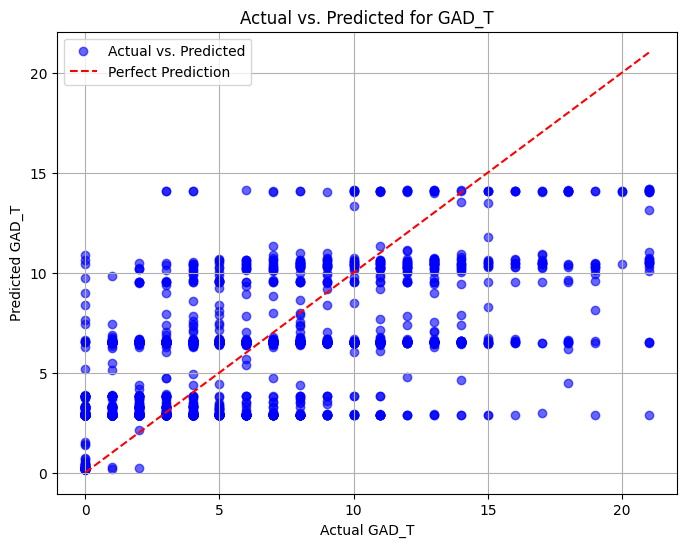

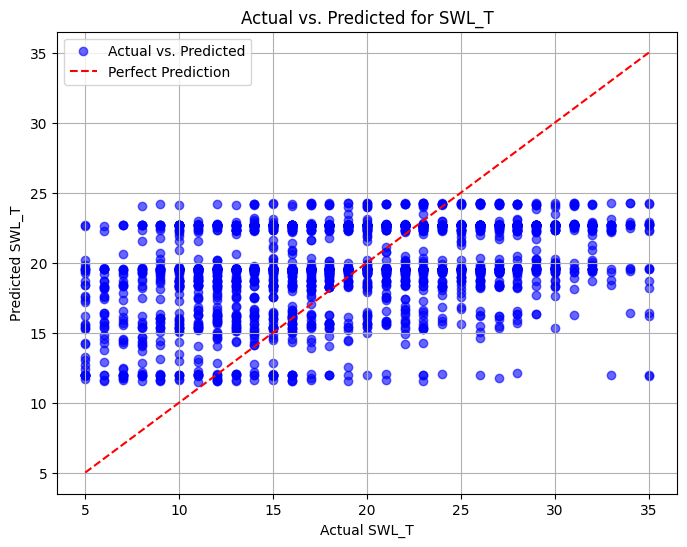

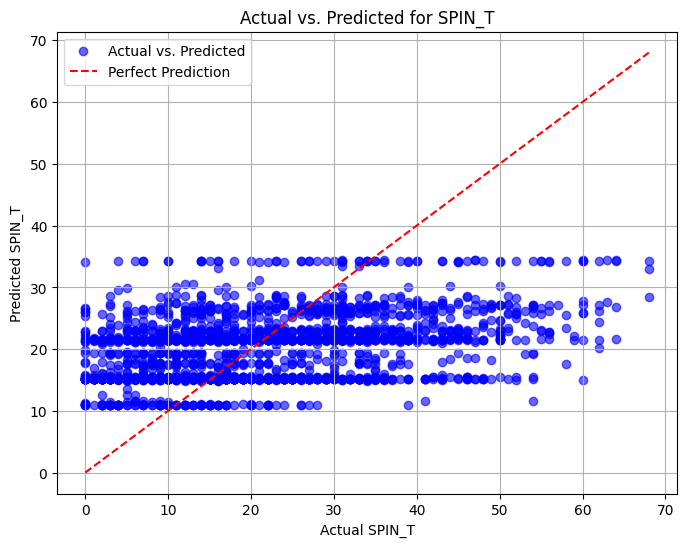

In [29]:
print("\n--- Visualising Predictions ---")

# Create scatter plots for each target variable
for i, target_col in enumerate(target_columns):
    plt.figure(figsize=(8, 6))

    # Scatter plot of actual vs. predicted values
    # Each blue dot represents an actual score on the x-axis and the model's predicted score on the y-axis.
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.6, color='blue', label='Actual vs. Predicted')

    # Add a line for perfect predictions (actual = predicted)
    # The red dashed line shows where points would fall if the model's predictions were exactly correct.
    max_val = max(y_test.iloc[:, i].max(), y_pred[:, i].max())
    min_val = min(y_test.iloc[:, i].min(), y_pred[:, i].min())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

    # Set title and labels for the plot
    plt.title(f'Actual vs. Predicted for {target_col}')
    plt.xlabel(f'Actual {target_col}')
    plt.ylabel(f'Predicted {target_col}')
    plt.legend() # Display the legend (Actual vs. Predicted, Perfect Prediction)
    plt.grid(True) # Add a grid for easier reading of values
    plt.show() # Show the plot


Finally, we will to create clear bar charts summarising the R-squared and MAE scores for each target variable. Identical to those that were used in Q1 to provide suitable means to compare the 2 sets of results. They also provide an easier way to see how accurate the network was when predicting each value. From the scatter plots though, we can already tell that the network was very inaccurate.



--- R-squared Scores ---
R-squared for GAD_T: 0.4355
R-squared for SWL_T: 0.1680
R-squared for SPIN_T: 0.1617


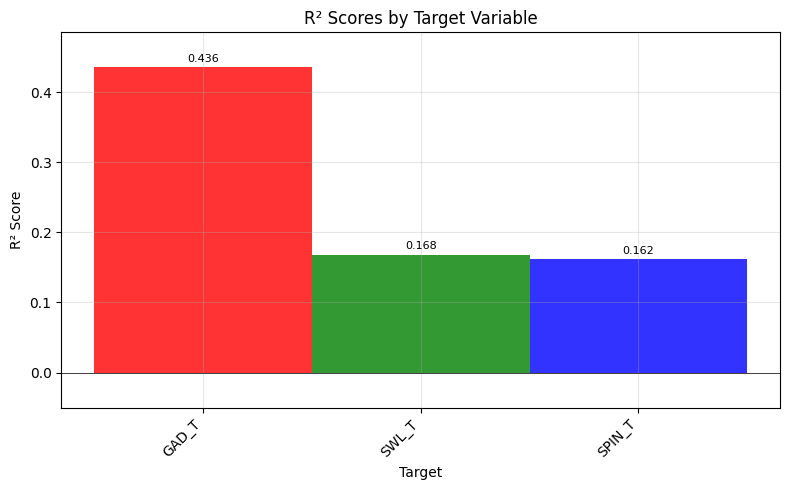


--- Mean Absolute Error Scores ---
MAE for GAD_T: 2.7130
MAE for SWL_T: 5.3947
MAE for SPIN_T: 9.9967


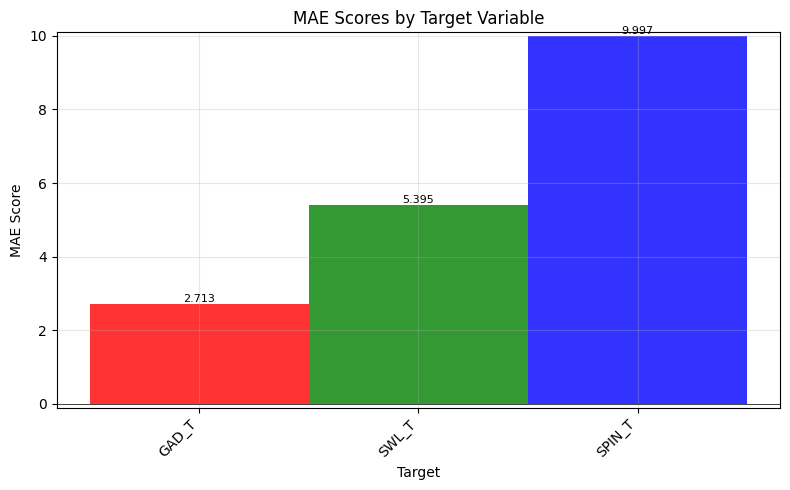

In [30]:
# Now, call the functions to demonstrate their usage
# These functions (imported from functions.py) will generate bar charts of R-squared and MAE values,
# providing a quick visual comparison of model performance across the different target variables.
plot_r2_values(y_test, y_pred, target_columns)
plot_mae_values(y_test, y_pred, target_columns)


# My Findings

Now that we have our visualisations we can compare the performance of a Neural Netwrok to our machine learning approaches. Instantly from our bar charts we can see a neural network produces very similar results to a random forest machine learing model.

This may be different if we were using a better data set. Due to our models and network trying to predict psychological scores, which is a very complex concept, they are unable to find patterns just from the features it is given in our data set. This being said, my neural network wouldn't learn even after trying over 10 different architectures changing layer configurations, activation functions, number of iterations and other things. This could mean there is an error in my code that is preventing my neural netwrok but after many attempts to fix this it always ended up randomly guessing as we see on the scatter plots. The neural network did somehow find pattterns though as we see it guessing similar values for all three targets. Which reinforces how hard it is to find accurate patterns when trying to predict psychological scores for different factors.

These factors could include:
- People providing false answers on the questionnaires and personal questions though this is unlikely
- The different lifestyles of the participants outside of playing games is a large factor that isn't taken into account.

And countless other factors that this dataset was unable to take into account due to the huge scope that is determining anxiety levels, life satisfaction and social phobia and gaming may just be a response to peoples levels instead of being the cause. If this is the case, then our information provides no patterns at all as the true cause of the scores lie elsewhere outside of the dataset, making it very challenging for a neural network or machine learning models to predict them.